White Dwarf


In [2]:

# url = "http://vizier.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad" offline 2025-10-22
url = "https://cdsarc.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad"


"https://cdsarc.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad"

In [3]:
catalog = download(url)

"/tmp/jl_RwHw9U7gHO"

In [4]:
using CSV
using DataFrames

In [5]:

df = CSV.read(catalog, DataFrame, comment="#", skipto=4, 
              types=[Float64, Float64], delim='\t', ignorerepeated=true, 
              silencewarnings=true)

Row,Mass,Rad
,Float64?,Float64?
1,0.92,missing
2,1.37,0.00434
3,1.3,0.00423
4,1.16,0.0067
5,1.03,0.00631
6,1.171,0.006503
7,0.83,0.01
8,0.89,missing
9,0.862,missing


In [6]:
dropmissing!(df)

Row,Mass,Rad
,Float64,Float64
1,1.37,0.00434
2,1.3,0.00423
3,1.16,0.0067
4,1.03,0.00631
5,1.171,0.006503
6,0.83,0.01
7,1.02,0.00782
8,0.9,0.00883
9,0.9,0.0088


In [7]:
using PyPlot

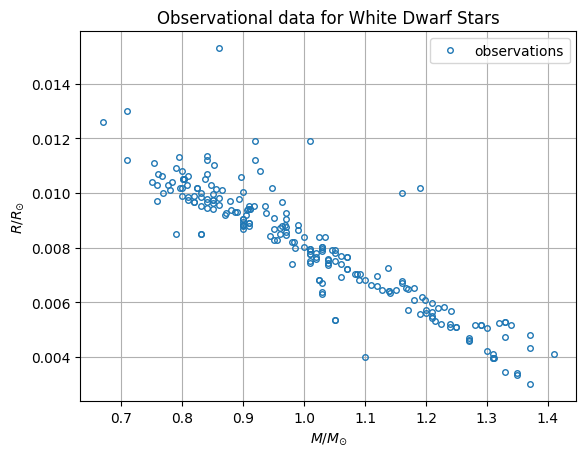

In [8]:
#plot(mass*0.71, radi*0.006, label="theory") 
plot(df.Mass, df.Rad, marker="o", linestyle="none", 
     fillstyle="none", markersize=4, label="observations")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
legend()
title("Observational data for White Dwarf Stars");

In [9]:

using OrdinaryDiffEqTsit5

In [10]:

"""
    white_dwarf_eqs!(dudr, u, p, r)

The right hand side of the system of 2 dimensionless differential 
equations describing the radial distribution of the density, rho(r),
and mass, m(r), inside a white dwarf star

     m' =  rho r^2
   rho' = -m rho /(gamma(\rho) r^2)

where gamma(rho) = rho^(2/3)/(3 sqrt(1 + rho^(2/3)))
"""
function white_dwarf_eqs!(dudr, u, p, r)
    m = u[1]
    rho = u[2]
    rho_c = p
    if rho >= 0.0
        w = rho^(2/3)
        gamma = w/(3 * sqrt(1 + w))
        dudr[1] = rho * r * r
        if (r > 1.e-6)
            dudr[2] = -m * rho/(gamma * r^2)
        else
            dudr[2] = -rho_c/3 * r * rho/gamma
        end
    else
        dudr[1] = 0.0
        dudr[2] = 0.0
    end
    return nothing
end

white_dwarf_eqs!

In [11]:

rho_c1 = 0.08      #  min density in the star center
rho_c2 = 100000.0  #  max density in the star center
np = 100

rhos = exp.(range(log(rho_c1), log(rho_c2), np))

100-element Vector{Float64}:
      0.07999999999999999
      0.09218811536303338
      0.10623310767734942
      0.12241787482416298
      0.14106841458484148
      0.1625603909728449
      0.18732670095580548
      0.2158661939786282
      0.24875371991850903
      0.2866517078603901
      0.3303235089155524
      0.3806487718378617
      0.4386411611373222
      ⋮
  21016.749801593018
  24218.68194081581
  27908.433058756797
  32160.323080277056
  37059.99467796262
  42706.13830906774
  49212.480064325006
  56710.07236838714
  65349.933671785635
  75306.09030376437
  86779.0817557806
 100000.00000000001

In [12]:

radi = zeros(np)
mass = zeros(np);

In [13]:
rspan = (0.0, 10.0)


(0.0, 10.0)

In [14]:

for i = 1:np 

    rho_c = rhos[i]
    
    # New initial conditions
    u0 = [0.0, rho_c]

    # Set up the new problem
    prob = ODEProblem(white_dwarf_eqs!, u0, rspan, rho_c)

    # Set up the callback
    condition(u, t, integrator) = u[2]  # stop integration when rho = 0.
    affect!(integrator) = terminate!(integrator)
    cb = ContinuousCallback(condition, affect!)

    # Integrate the ODEs
    sol = solve(prob, Tsit5(), callback=cb)

    # Store the relevant part: the radius and the mass of the white dwarf.
    radi[i] = sol.t[end]
    mass[i] = sol.u[end][1]
    
end

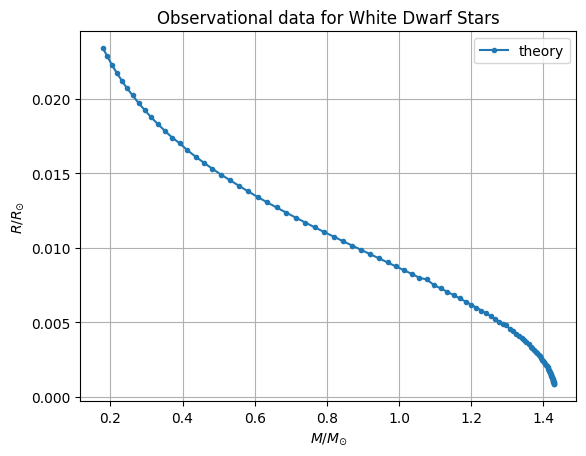

In [18]:
plot(mass * 0.71, radi * 0.006, marker=".", label="theory")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
legend()
title("Observational data for White Dwarf Stars");